In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")

else:
  device = torch.device("cpu")

In [4]:
data_path = "/content/drive/MyDrive/BrainTumour/brain_tumor_dataset"

In [5]:
img_size = 120

In [6]:
img_transform = transforms.Compose([
transforms.Resize((img_size, img_size)),       transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [7]:
img_data = ImageFolder(root=data_path, 
              transform= img_transform )

In [8]:
img_data.class_to_idx

{'no': 0, 'yes': 1}

In [9]:
len(img_data)

263

In [10]:
train_data, test_data = random_split(img_data,[200,63])

In [11]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [12]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 3, 120, 120]) torch.Size([16])


#Visualizing the Data

In [13]:
def show_img_batch(data):
    for images, labels in data:
        plt.figure(figsize=(20,15))
        plt.imshow(make_grid
        (images,nrow=16).permute(1,2,0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


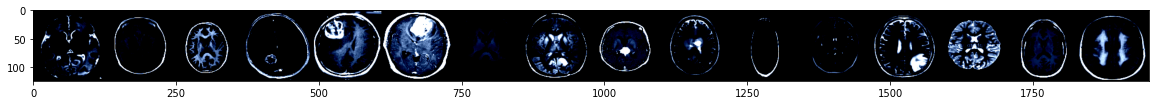

In [14]:
show_img_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


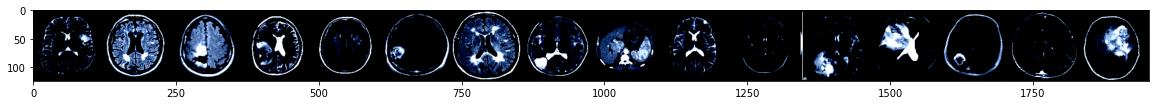

In [15]:
show_img_batch(test_loader)

#BUILD THE MODEL

In [16]:
class CNN_seq(nn.Module):
    def __init__(self, kernel_size=3,out_channels1=16, out_channels2=32, out_channels3=64 ):
        super(CNN_seq, self).__init__()
        
        self.features = nn.Sequential(
                        nn.Conv2d(in_channels=3,
                        out_channels=out_channels1, 
                        kernel_size=kernel_size),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(in_channels=
                        out_channels1, 
                        out_channels=out_channels2, 
                        kernel_size=kernel_size),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(in_channels=
                        out_channels2, 
                        out_channels=out_channels3,
                        kernel_size=kernel_size),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
                          nn.Linear(13*13*64, 256),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(256,128),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(128, 2))
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1, 13*13*64)
        x = self.classifier(x)
        
        return x

In [17]:
model = CNN_seq()
print(model.parameters)

<bound method Module.parameters of CNN_seq(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10816, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)>


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#TRAINING THE MODEL

In [19]:
def CNN_train(loss_fn, optimizer):

    epochs = 10

    training_acc = []
    training_loss = []
    testing_acc = []
    testing_loss = []

    for epoch in range(epochs):

        train_acc = 0.0
        train_loss = 0.0

        model.train()

        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()

            predictions = torch.argmax(output, 1)

            train_acc += (predictions == labels).sum().item()
            train_loss += loss.item()

        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))

        model.eval()

        test_acc = 0.0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                loss = loss_fn(output, labels)

                predictions = torch.argmax(output ,1)

                test_acc += (predictions == labels).sum().item()
                test_loss += loss.item()

            testing_acc.append(test_acc/len(test_data))
            testing_loss.append(test_loss/len(test_loader))

        print("Epochs:{},Training Accuracy:{:.2f},Training Loss:{:.2f},Testing Accuracy:{:.2f},Testing Loss:{:.2f}".
              format(epoch+1,train_acc/len(train_data), train_loss/len(train_loader), test_acc/len(test_data),
        test_loss/len(test_loader)))
    return model

In [20]:
CNN_train(loss_fn,optimizer)

Epochs:1,Training Accuracy:0.65,Training Loss:0.65,Testing Accuracy:0.75,Testing Loss:0.52
Epochs:2,Training Accuracy:0.72,Training Loss:0.57,Testing Accuracy:0.79,Testing Loss:0.49
Epochs:3,Training Accuracy:0.79,Training Loss:0.51,Testing Accuracy:0.73,Testing Loss:0.48
Epochs:4,Training Accuracy:0.80,Training Loss:0.48,Testing Accuracy:0.76,Testing Loss:0.48
Epochs:5,Training Accuracy:0.80,Training Loss:0.38,Testing Accuracy:0.83,Testing Loss:0.61
Epochs:6,Training Accuracy:0.83,Training Loss:0.37,Testing Accuracy:0.73,Testing Loss:0.44
Epochs:7,Training Accuracy:0.89,Training Loss:0.25,Testing Accuracy:0.81,Testing Loss:0.50
Epochs:8,Training Accuracy:0.89,Training Loss:0.29,Testing Accuracy:0.83,Testing Loss:0.46
Epochs:9,Training Accuracy:0.94,Training Loss:0.16,Testing Accuracy:0.83,Testing Loss:0.51
Epochs:10,Training Accuracy:0.97,Training Loss:0.11,Testing Accuracy:0.83,Testing Loss:0.54


CNN_seq(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10816, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [21]:
def predict_image(img, labels):
    x = img.unsqueeze(0)
    y = model(x)
    
    pred = torch.argmax(y, dim=1)
    
    return img_data.classes[pred]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: no Predicted Label: no


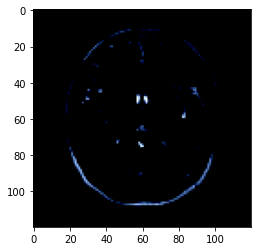

In [22]:
img, label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual Label:" ,img_data.classes[label], "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: yes Predicted Label: yes


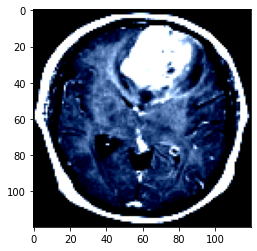

In [23]:
img, label = test_data[44]
plt.imshow(img.permute(1,2,0))
print("Actual Label:" ,img_data.classes[label], "Predicted Label:", predict_image(img, model))